<a href="https://colab.research.google.com/github/algharak/BERTenhance/blob/master/LoanApprovalKaggle_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
# Read train and test datasets into pandas dataframes
train_path = 'drive/MyDrive/projects/LoanApprovalKaggle/data/train.csv'
test_path = 'drive/MyDrive/projects/LoanApprovalKaggle/data/test.csv'
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


In [3]:
# Import the necessary libraries
from scipy import stats
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from xgboost import XGBClassifier,plot_importance
import lightgbm as lgb

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
# Function to plot histogram of the features and targets
def plot_histplot_for_train_df(x):
   plt.figure(figsize=(5, 3))
   sns.histplot(data=train_df, x=x)
   plt.show()

In [5]:
train_df.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


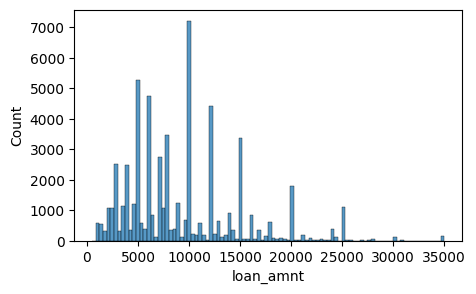

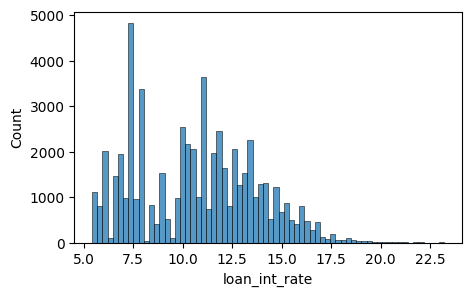

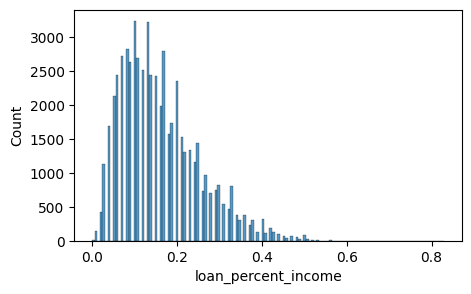

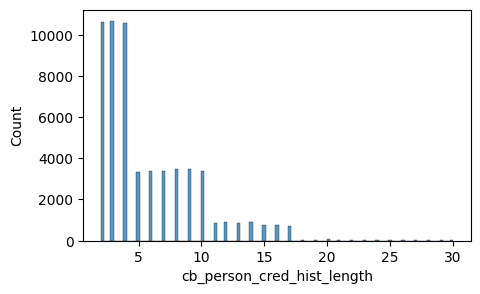

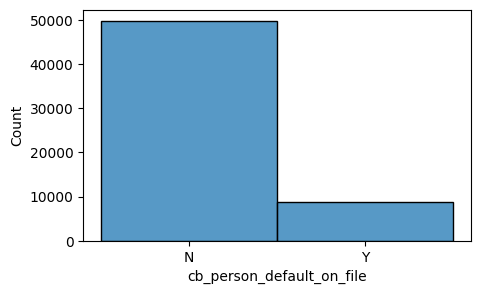

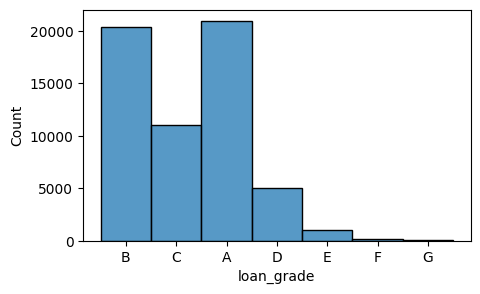

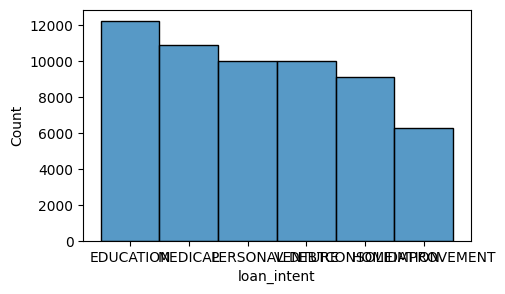

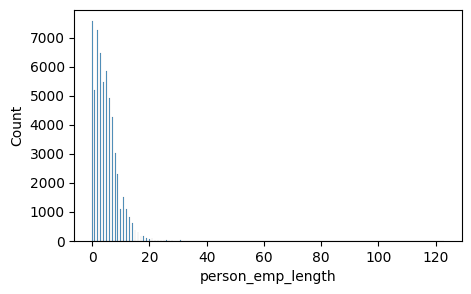

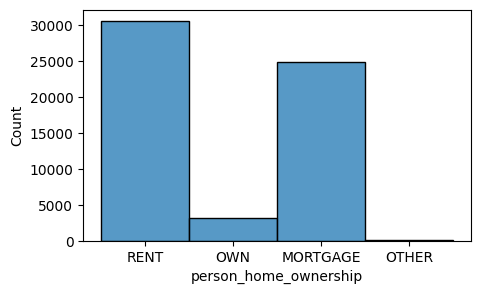

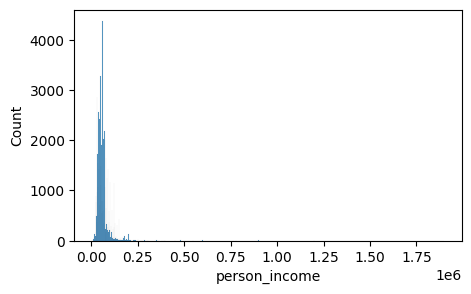

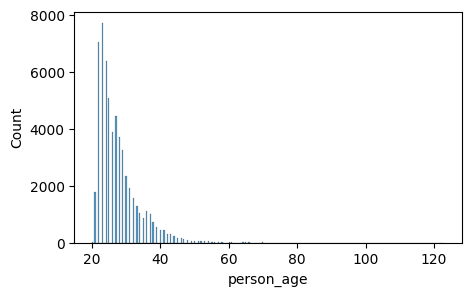

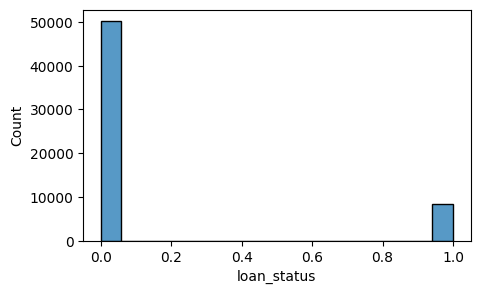

In [7]:
# plot histogram of various columns
# process the loan amount first
plot_histplot_for_train_df('loan_amnt')
plot_histplot_for_train_df('loan_int_rate')
plot_histplot_for_train_df('loan_percent_income')
plot_histplot_for_train_df('cb_person_cred_hist_length')
plot_histplot_for_train_df('cb_person_default_on_file')
plot_histplot_for_train_df('loan_grade')
plot_histplot_for_train_df('loan_intent')
plot_histplot_for_train_df('person_emp_length')
plot_histplot_for_train_df('person_home_ownership')
plot_histplot_for_train_df('person_income')
plot_histplot_for_train_df('person_age')
plot_histplot_for_train_df('loan_status')


In [8]:
# Check to see if there is missing entries
pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False)).head(20)
pd.DataFrame(test_df.isnull().sum().sort_values(ascending=False)).head(20)


,0
id,0
person_age,0
person_income,0
person_home_ownership,0
person_emp_length,0
loan_intent,0
loan_grade,0
loan_amnt,0
loan_int_rate,0
loan_percent_income,0


In [9]:
# create new features
train_df['TotalInt_'] = train_df["loan_amnt"]*train_df['loan_int_rate']
train_df['Income_to_Int_'] = (train_df['person_income']*12)/(train_df["loan_amnt"]*train_df['loan_int_rate'])
train_df['Income_age_'] = train_df['person_income']/train_df["person_age"]

test_df['TotalInt_'] = test_df["loan_amnt"]*test_df['loan_int_rate']
test_df['Income_to_Int_'] = (test_df['person_income']*12)/(test_df["loan_amnt"]*test_df['loan_int_rate'])
test_df['Income_age_'] = test_df['person_income']/test_df["person_age"]


In [10]:
# Remove the outliers
train_df = train_df.loc[train_df['person_emp_length']<40]
train_df = train_df.loc[train_df['person_income']<500000]
train_df = train_df.loc[train_df['person_age']<80]

In [12]:
# List of numerical features
log_num_cols = ['person_age', 'person_income',
       'person_emp_length', 'loan_amnt','loan_int_rate', 'loan_percent_income', 'TotalInt_',
       'Income_to_Int_', 'Income_age_','cb_person_cred_hist_length']

In [14]:
# Transform the numerical columns using Sklearn pipeline.  Take the log first and then use standard scaling
from sklearn.preprocessing import FunctionTransformer

def log_transform(x):
    return np.log1p(1+x)

log_transformer = FunctionTransformer(log_transform)
numeric_transformer = Pipeline(
    steps=[("trans",log_transformer) , ("scaler", StandardScaler())])
preprocessor = ColumnTransformer(
    transformers=[("num", numeric_transformer, log_num_cols)])
train_df[log_num_cols] = preprocessor.fit_transform(train_df)
test_df[log_num_cols] = preprocessor.fit_transform(test_df)

In [15]:
# Download category encoding libraries
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 1.9 MB/s eta 0:00:00


In [16]:
#create train and validation sets in dataframe format
X_trf = train_df.drop(['loan_status','id'], axis=1)
y_trf = train_df['loan_status']
X_tef = test_df.drop(['id'], axis=1)
X_tef.head()


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,TotalInt_,Income_to_Int_,Income_age_
0,-0.832609,0.403731,RENT,-0.205201,HOMEIMPROVEMENT,F,1.845973,1.500477,2.149931,N,-1.240302,2.225861,-1.670924,0.729692
1,-0.204502,1.129433,MORTGAGE,0.582503,PERSONAL,C,0.412675,0.723447,-0.649902,Y,-0.344520,0.661718,-0.018999,1.169332
2,-0.204502,-1.426541,RENT,0.358711,VENTURE,E,-1.020343,1.816411,-0.309659,Y,-1.240302,-0.182590,-0.727777,-1.292399
3,1.032236,-0.304038,RENT,0.100361,DEBTCONSOLIDATION,A,-0.145190,-0.491173,-0.197309,N,0.551262,-0.318703,0.060835,-0.716135
4,-0.204502,1.262656,MORTGAGE,0.956481,HOMEIMPROVEMENT,D,1.046898,1.627130,-0.085482,Y,-0.344520,1.569280,-0.782778,1.297704


In [18]:
# Encode the categorical features for both training and testing datasets.
from category_encoders.target_encoder import TargetEncoder
categ_cols = ['person_home_ownership','loan_intent', 'loan_grade',
       'cb_person_cred_hist_length','cb_person_default_on_file']
t_enc = TargetEncoder(cols=categ_cols)
t_enc.fit(X_trf, y_trf)
X_trf=t_enc.transform(X_trf)
X_tef=t_enc.transform(X_tef)
X_trf.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,TotalInt_,Income_to_Int_,Income_age_
0,1.637623,-1.087894,0.222596,-1.740146,0.107778,0.102404,-0.376994,0.373020,0.139502,0.115152,0.166486,-0.173317,-0.545393,-1.720446
1,-1.055747,-0.049872,0.013712,0.581379,0.178166,0.135424,-1.008424,0.898751,-0.991154,0.115152,0.151572,-0.524226,0.436963,0.387937
2,0.364052,-1.518491,0.013712,0.955060,0.132847,0.049158,-0.376994,-0.494682,0.577240,0.115152,0.131767,-0.524226,-0.468929,-1.616900
3,0.540178,0.442957,0.222596,1.742141,0.092854,0.102404,0.702627,0.256722,0.139502,0.115152,0.131476,0.732748,-0.502992,0.202512
4,-1.055747,0.102504,0.222596,-0.579383,0.178166,0.049158,-0.376994,-1.310616,-0.646321,0.115152,0.144619,-0.869924,0.907741,0.534974


In [19]:
X_tr,X_va,y_tr,y_va = train_test_split(X_trf,y_trf,test_size = 0.2, shuffle=True,random_state = 23,stratify=y_trf)

In [20]:
print(type(X_tr))
X_tr.head()

<class 'pandas.core.frame.DataFrame'>


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,TotalInt_,Income_to_Int_,Income_age_
2629,1.778074,0.595333,0.013712,0.778621,0.092854,0.049158,1.334231,-1.449860,0.900375,0.115152,0.152062,0.578486,-0.268659,-0.154177
12787,1.493523,0.102504,0.222596,-1.740146,0.092854,0.102404,-2.087527,0.219295,-1.458787,0.115152,0.131920,-1.743701,1.885288,-0.514385
57594,-0.402342,-1.830990,0.222596,-0.579383,0.189459,0.593756,0.254523,1.090384,2.252364,0.298954,0.144619,0.663970,-1.574583,-1.602170
24335,5.038838,-3.049251,0.222596,-1.740146,0.178166,0.102404,-2.087527,0.111343,-0.194129,0.115152,0.296228,-1.786872,-0.173684,-4.958320
13827,-1.055747,-1.428336,0.222596,-1.740146,0.189459,0.102404,-1.172483,0.020241,-0.532471,0.115152,0.144619,-1.015992,0.061354,-0.941808


In [21]:
# correlation_matrix = train_df.corr(numeric_only=True)
# plt.figure(figsize=(20,12))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

In [22]:
# remove redundant features
# train_df.columns
# train_df = train_df.drop('person_emp_length',axis=1)
# train_df.head()

In [23]:
# Setting up the XGBClassifier and running a grid search to find optimal hyperparameters
XGB = XGBClassifier(random_state=13)
param_grid_XGB = {
    'learning_rate': [0.05],
    'n_estimators': [300],
    'max_depth': [6],
    'min_child_weight': [1],
    'gamma': [0, 0.2],
    'subsample': [0.5],
    'scale_pos_weight':[4],
    'colsample_bytree': [0.5]}
xgb_cv = GridSearchCV(XGB, param_grid_XGB, cv=3, scoring='roc_auc', n_jobs=-1)
xgb_cv.fit(X_tr, y_tr)
print(xgb_cv.best_params_)
print(xgb_cv.best_score_)

{'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'scale_pos_weight': 4, 'subsample': 0.5}
0.9493682557291763


In [ ]:
import matplotlib.pyplot as plt
param_grid_XGB = {
    'learning_rate': 0.05,
    'n_estimators': 2000,
    'max_depth': 2,
    'min_child_weight': 1,
    'gamma': 0,
    'subsample': 0.5,
    'scale_pos_weight':4,
    'colsample_bytree': 0.5,
    'verbose':False}

eval_set = [(X_tr,y_tr),(X_va,y_va)]
eval_metric = ["auc"]
xgb_final = XGBClassifier(**param_grid_XGB,eval_metric=eval_metric)
xgb_final.fit(X_tr, y_tr, eval_set=eval_set, verbose=True)

results = xgb_final.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.show()




In [25]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier(random_state=13)
param_grid_RFC = {
    'max_depth': [5, 15],
    'n_estimators': [100, 200],
    'min_samples_split': [3, 10]
}
rfc_cv = GridSearchCV(RFC, param_grid_RFC, cv=3, scoring='roc_auc', n_jobs=-1)
rfc_cv.fit(X_tr, y_tr)
print(rfc_cv.best_params_)
print(rfc_cv.best_score_)

{'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 200}
0.9343487173133832


In [26]:
from sklearn.metrics import roc_auc_score
eval_set = [(X_tr,y_tr),(X_va,y_va)]
eval_metric = ["auc"]
rfc_final = RandomForestClassifier(max_depth= 15, min_samples_split=10,n_estimators= 200,random_state=13)

rfc_final.fit(X_tr, y_tr)
y_pred = rfc_final.predict(X_va)
roc_auc_score(y_pred,y_va)

0.9462149729471321

In [27]:
import lightgbm as lgb
lgbm_final = lgb.LGBMClassifier()
lgbm_final.fit(X_tr, y_tr)
y_pred=lgbm_final.predict(X_va)
roc_auc_score(y_pred,y_va)

[LightGBM] [Info] Number of positive: 6678, number of negative: 40206
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003719 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1640
[LightGBM] [Info] Number of data points in the train set: 46884, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.142437 -> initscore=-1.795198
[LightGBM] [Info] Start training from score -1.795198


0.945980960375832

In [28]:
# Voting ensemble
from sklearn.ensemble import VotingClassifier
ensemble = [('lightGBM',lgbm_final),('RandomForest',rfc_final),('XGBoost',xgb_final)]
final_mod = VotingClassifier(estimators=ensemble,voting='soft')
final_mod = final_mod.fit(X_tr,y_tr)
y_pred = final_mod.predict(X_va)
roc_auc_score(y_pred,y_va)




[LightGBM] [Info] Number of positive: 6678, number of negative: 40206
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1640
[LightGBM] [Info] Number of data points in the train set: 46884, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.142437 -> initscore=-1.795198
[LightGBM] [Info] Start training from score -1.795198


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:39:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


0.9424895056476911